**YOUR NAMES HERE**

Fall 2023

CS 343: Neural Networks

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

2023-11-30 09:03:14.869881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## TensorFlow install test

*Sanity check that Tensorflow is installed correctly:*

Executing the following cell should print 3 

In [2]:
tf.print(tf.reduce_sum([tf.constant(1), tf.constant(2)]))

3


# Project 4 | Transfer Learning

## Task 1: Implement ConvNet4 in TensorFlow

Construct the familiar ConvNet4 neural network architecture from last project in TensorFlow's high level `Keras::Sequential` API. Also like your last project, train on the STL-10 training set and test on the STL-10 training set.

### 1a. Use the high level `Keras::Sequential` API in Tensorflow 2 to implement the architecture of ConvNet4 from the last project. Train and test your network on the STL-10 dataset. 

**Goal:** Achieve ≥ 50% on either the validation set or test set. *For our purposes, getting ≥ 50% validation accuracy at any point during training is enough (i.e. doesn't need to be at the very end of training).*

#### Notes

- You should use the usual STL-10 data acquisition and preprocessing code from your last project. You can use the default split, or modify it yourself.
- You don't need to do a hyperparameter search. Values that worked on the CNN project should get you in the ballpark here. The goal is to show that you know how to put together a `keras::Sequential` model and have it work successfully.
- You may have to tweak the hyperparameters by hand a little (number of epochs, weight initialization method, number of hidden units, etc.) to hit your accuracy target, but it should not take too much effort.
- TensorFlow needs the RGB color channel AFTER the spatial dimensions. For example: (32, 32, 3), not (3, 32, 32). You may therefore need to slightly modify the preprocesssing pipeline for this project.

#### Keras Sequential workflow

Recall the `Keras::Sequential` common workflow:

- Build structure of network with `keras::Sequential`.
- Compile network with your choice of optimizer, loss, and metrics.
- Fit the model (remembering to pass in the appropriate training and validation sets). This results a history object that can be used to examine training/validation accuracy and loss.
- Evaluate the model on the test set. This returns test loss and accuracy.

#### Helpful documentation

These documentation pages should be helpful:
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

In [3]:
import load_stl10_dataset
from preprocess_data import load_stl10

In [4]:
#get data and split it
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = load_stl10(
    n_train_samps=4398, n_test_samps=400, n_valid_samps=200, n_dev_samps=2, scale_fact=6)

# Transpose dimensions for x_train
x_train = np.transpose(x_train, (0, 2, 3, 1))

# Transpose dimensions for x_test
x_test = np.transpose(x_test, (0, 2, 3, 1))

# Transpose dimensions for x_val
x_val = np.transpose(x_val, (0, 2, 3, 1))

# Transpose dimensions for x_dev
x_dev = np.transpose(x_dev, (0, 2, 3, 1))

# Print the shape of the transposed x_train
print(x_train.shape)

# One-hot encode the target data
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val= tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_dev = tf.keras.utils.to_categorical(y_dev, num_classes=10)

print(y_train.shape)


Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 16, 16, 3)
Labels are: (5000,)
(4398, 16, 16, 3)
(4398, 10)


In [5]:
#network has following structure: 

#convolution, max-pooling, dense, denseout
import tensorflow as tf

def Conv4_Keras(input_shape=(32, 32, 3), n_kers=(32,), ker_sz=(7, 7), dense_interior_units=(100,), pool_size=(2, 2), pooling_strides=(2, 2), n_classes=10, wt_scale=1e-3, reg=0.001):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    # Convolutional layer with weight scaling and regularization
    model.add(tf.keras.layers.Conv2D(filters=n_kers[0], kernel_size=ker_sz, padding='same',
                                     activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=wt_scale),
                                     kernel_regularizer=tf.keras.regularizers.l2(reg)))
    
    model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=pooling_strides))
    model.add(tf.keras.layers.Flatten())
    
    # Dense layer with weight scaling and regularization
    model.add(tf.keras.layers.Dense(units=dense_interior_units[0], activation='relu',
                                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=wt_scale),
                                    kernel_regularizer=tf.keras.regularizers.l2(reg)))
    
    # Output layer without weight scaling and regularization
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))

    return model




In [6]:
model = Conv4_Keras(input_shape = (16,16,3), reg = 0.008)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000105)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train,validation_data = (x_val, y_val), batch_size=300, epochs = 40)

Epoch 1/40
15/15 [==============================] - 2s 64ms/step - loss: 2.2151 - accuracy: 0.1687 - val_loss: 2.1310 - val_accuracy: 0.1900
Epoch 2/40
15/15 [==============================] - 1s 43ms/step - loss: 1.9768 - accuracy: 0.2767 - val_loss: 1.9531 - val_accuracy: 0.2700
Epoch 3/40
15/15 [==============================] - 1s 42ms/step - loss: 1.8193 - accuracy: 0.3406 - val_loss: 1.8751 - val_accuracy: 0.3100
Epoch 4/40
15/15 [==============================] - 1s 43ms/step - loss: 1.7376 - accuracy: 0.3627 - val_loss: 1.7856 - val_accuracy: 0.3150
Epoch 5/40
15/15 [==============================] - 1s 43ms/step - loss: 1.6769 - accuracy: 0.3929 - val_loss: 1.7590 - val_accuracy: 0.3250
Epoch 6/40
15/15 [==============================] - 1s 42ms/step - loss: 1.6347 - accuracy: 0.4081 - val_loss: 1.7276 - val_accuracy: 0.3600
Epoch 7/40
15/15 [==============================] - 1s 43ms/step - loss: 1.5857 - accuracy: 0.4334 - val_loss: 1.6542 - val_accuracy: 0.3900
Epoch 8/40
15

### 1b. Make 2 "high quality" plots showing the following

- Training and validation accuracy (y axis) over training epochs (x axis).
- Training and validation loss (y axis) over epochs (x axis).

A high quality plot consists of:
- A useful title
- X and Y axis labels
- A legend

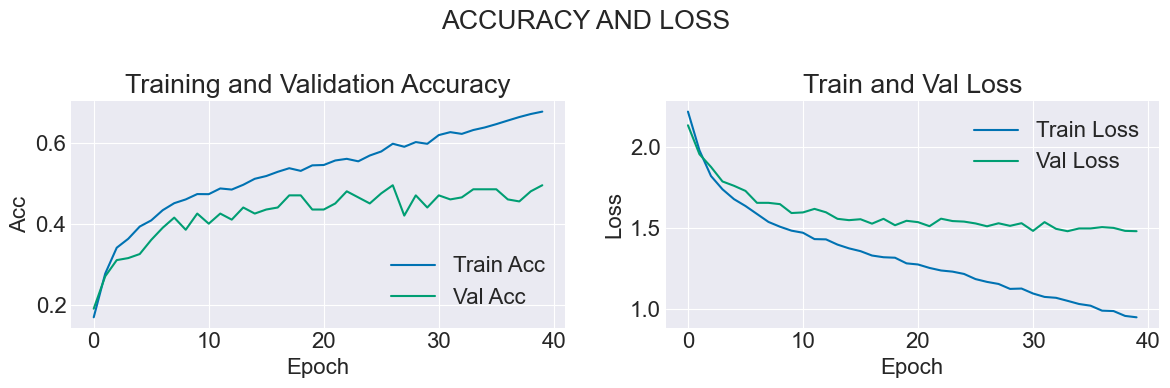

In [7]:
#we will use pyplot
plt.figure(figsize=(12, 4))

# we will make a two panel plot

#accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Acc')
plt.plot(hist.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()


# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Val Loss')

plt.suptitle("ACCURACY AND LOSS")
plt.tight_layout()
plt.show()

### 1c. Visualize predictions

Make a 5x5 grid of the first 25 images in the test dataset. Label each with the predicted class label string (English label, not an int code).

13/13 [==============================] - 0s 3ms/step


<Figure size 1200x1200 with 0 Axes>

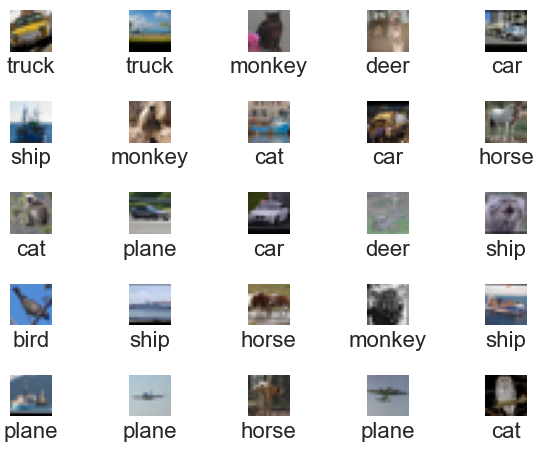

In [8]:
labels = {0:'plane',1:'bird',2:'car',3:'cat',4:'deer',5:'dog',6:'horse',7:'monkey',8:'ship',9:'truck'}
predicted = model.predict(x_test)
predicted_int = np.argmax(predicted, axis=-1)
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))


plt.figure(figsize=(12, 12))
fig, axs = plt.subplots(5,5)

for i in range(5):
    for j in range(5):
        axs[i,j].imshow(x_test[5*i+j])
        axs[i,j].set_xlabel(labels[predicted_int[5*i+j]])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])

plt.tight_layout()


### 1d. Questions

**Question 1:** What accuracy do you get on the STL-10 test set? Briefly summarize the hyperparameters that you used to obtain this result.

**Question 2:** How do the loss and accurary results compare to the CNN project?

**Question 3:** Identify a few misclassifications. Is there a discernable pattern?

**Answer 1:** 

**Answer 2:** 

**Answer 3:** 

## Task 2: Transfer learning

Here you will use Tensorflow 2 to download the pre-trained MobileNetV2 network (you may also use another network like InceptionV3, VGG19, or EfficientNet, but MobileNetV2 likely will run noticeably faster on your machine). We will use transfer learning to accelerate training to solve a novel problem: **the binary classification task of discriminating whether an image is of a hotdog or not.**

### Overview

- Remove the output layer, add a new Dense output layer.
- Freeze (disable) training on all non-output layers.
- Train the last layer on a food dataset. Assess performance. Plot some example images and their classification below.

### 2a. Download and load in hotdot image dataset

Download the **food dataset** from the project website, copy it into a `data` subfolder in your project directory.

Run the below code to load in the hot-dog-or-not dataset. Check the shapes to ensure everything is loaded in correctly. 

In [9]:
ds_base_dir='numpy/'

hotdog_train_x = np.load(os.path.join(ds_base_dir, 'train_x.npy'))
hotdog_train_y = np.load(os.path.join(ds_base_dir, 'train_y.npy'))
hotdog_test_x = np.load(os.path.join(ds_base_dir, 'test_x.npy'))
hotdog_test_y = np.load(os.path.join(ds_base_dir, 'test_y.npy'))

print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (16000, 96, 96, 3)')
print(f'Test hotdog split shape: {hotdog_test_x.shape}. Should be (4000, 96, 96, 3)')

Training hotdog split shape: (16000, 96, 96, 3). Should be (16000, 96, 96, 3)
Test hotdog split shape: (4000, 96, 96, 3). Should be (4000, 96, 96, 3)


### 2b. Normalize hotdog dataset

Standardize both the train and test dataset according to the **same statistics** computed from the **training set**.

In [10]:
hotdog_train_x = (hotdog_train_x-hotdog_train_x.min(axis = 0))/(hotdog_train_x.max(axis = 0)-hotdog_train_x.min(axis = 0))
hotdog_test_x = (hotdog_test_x-hotdog_train_x.min(axis = 0))/(hotdog_train_x.max(axis = 0)-hotdog_train_x.min(axis = 0))

### 2c. Create hotdog validation set

Set aside the last 20% of the training set as the validation set

In [11]:

hotdog_val_x = hotdog_train_x[-int((.2*len(hotdog_train_x))):]
hotdog_val_y = hotdog_train_y[-int((.2*len(hotdog_train_x))):]
hotdog_train_x = hotdog_train_x[:int(len(hotdog_train_x) - (.2*len(hotdog_train_x)))]
hotdog_train_y = hotdog_train_y[:int(len(hotdog_train_y) - (.2*len(hotdog_train_y)))]

print(f'Validation hotdog split shape: {hotdog_val_x.shape}. Should be (3200, 96, 96, 3)')
print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (12800, 96, 96, 3)')

Validation hotdog split shape: (3200, 96, 96, 3). Should be (3200, 96, 96, 3)
Training hotdog split shape: (12800, 96, 96, 3). Should be (12800, 96, 96, 3)


### 2d. Load in pre-trained MobileNetV2 network.

Load in a pre-trained MobileNetV2 network (look up constructor in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) or look at the tutorial from class) and set it to a variable called `model`. Remember to make the network not trainable. Calling the `summary()` method on the network object should show you a table with many rows. The top and bottom rows should be:


    input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                                            
    __________________________________________________________________________________________________
    out_relu (ReLU)                (None, 3, 3, 1280)   0           ['Conv_1_bn[0][0]']              
                                                                                                  
==================================================================================================

and you should see the following at the bottom:

    Total params: 2,257,984
    Trainable params: 0
    Non-trainable params: 2,257,984

In [12]:
model = tf.keras.applications.MobileNetV2(input_shape=hotdog_train_x.shape[1:],include_top=False, weights='imagenet')
model.trainable = False
model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

### 2e. Create augmented model

Create a new `keras::Sequential` augmented model with an output layer that has the correct number of units to deal with the hot-dog or not problem with your choice of optimizer, an appropriate loss, and metric(s).

#### Helpful links

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

https://www.tensorflow.org/api_docs/python/tf/losses

In [46]:
aug_net = tf.keras.Sequential(
[model,
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1, activation = 'sigmoid')])
aug_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
aug_net.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 11520)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 11521     
                                                                 
Total params: 2269505 (8.66 MB)
Trainable params: 11521 (45.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [47]:
loss, acc = aug_net.evaluate(hotdog_test_x, hotdog_test_y)
print(acc, loss)

125/125 [==============================] - 16s 114ms/step - loss: 0.9833 - accuracy: 0.5117
0.5117499828338623 0.9833168387413025


### 2f. Questions

**Question 4:** What is the accuracy and loss for the network with the untrained output layer on the test set? Explain why you got the accuracy value that you did.

**Question 5:** Briefly defend your choice of number of units in the output layer.

**Answer 4:**  accuracy: ~.54 and loss: ~ 5.8.  This is close to random chance for a binary classification which makes sense since we haven't trainded our model to classify hotdogs it only has been trained on the previous dataset. therefore we expect it to perfrom at random chance.

**Answer 5:** Since we are doing binary classifiaction we only need one ouptut unit: its either a hotdog (activated) or not (not activated).

### 2g. Fit the augmented model on the hotdog training data

Setting the verbose optional parameter to 2 will give you helpful printouts of performance on the validation set as it completes every epoch of training.

#### Training goal

You should aim to achieve at least 85% accuracy on the validation set. If everything is set up properly, you should only need to train for a very small number of epochs.


#### Note

If training time is taking much more than a few minutes per epoch on your computer, you could try reducing the number of data samples in train and validation. For example, by default train `N = 12800`. Try `N = 6400` instead. You could do the same for the validation set.

In [48]:
hist = aug_net.fit(hotdog_train_x, hotdog_train_y, batch_size=256, epochs=3, validation_data=(hotdog_val_x, hotdog_val_y) )

Epoch 1/3
50/50 [==============================] - 49s 902ms/step - loss: 0.4786 - accuracy: 0.7912 - val_loss: 0.3065 - val_accuracy: 0.8637
Epoch 2/3
50/50 [==============================] - 45s 900ms/step - loss: 0.2411 - accuracy: 0.8981 - val_loss: 0.2441 - val_accuracy: 0.8981
Epoch 3/3
50/50 [==============================] - 45s 909ms/step - loss: 0.1786 - accuracy: 0.9349 - val_loss: 0.2163 - val_accuracy: 0.9144


### 2h. Plot hotdog results

Produce 2 high quality plots showing the following:

- Training and validation loss over epoch.
- Training and validation accuracy over epoch.

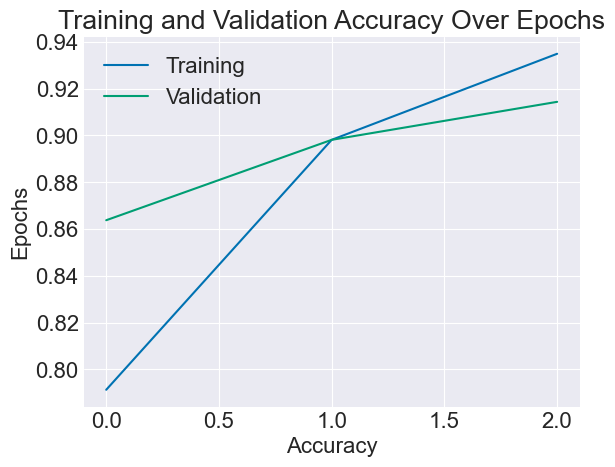

In [49]:
train_acc_plt = plt.plot(hist.history['accuracy'], label="Training")
val_acc_plt = plt.plot(hist.history['val_accuracy'], label="Validation")
plt.legend()
plt.title("Training and Validation Accuracy Over Epochs")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.show()

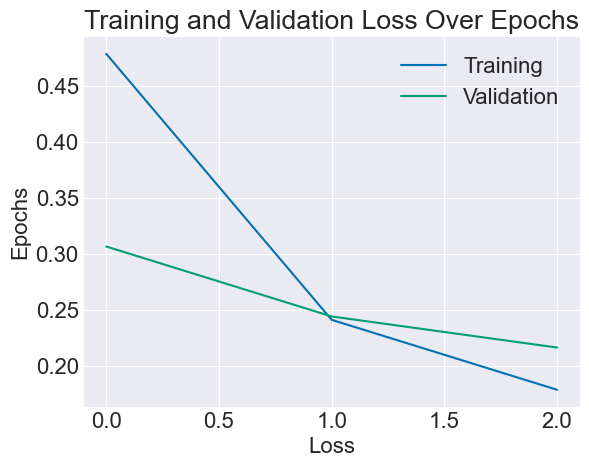

In [50]:
train_loss_plt = plt.plot(hist.history['loss'], label="Training")
val_loss_plt = plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.show()

### 2i. Visualize predictions on test set

Use your trained hotdog classifier to get the predicted classes for the first 25 **test set** samples. Then create a 5x5 grid of the first 25 test samples and label each with the predicted class string (English label, not an int code).
- If the prediction is correct, color the label *blue*.
- If the prediction is incorrect, color the label *red*.

**Note:**
- Depending on how you get the network predictions, TensorFlow may give you a vector of class probabilities. This could be shape `(N, 2)` or `(N,)`, depending on the output layer activation function that you used. Remember that if you have these probabilities, you need to recover the predicted class index (e.g. `0`, `1`) before you can label your plots.
- If `imshow` gives you warnings about clipping, check the range of the test samples. If your max is slightly higher than 1, either ignore the warning or divide by the max. 

In [51]:
loss, acc = aug_net.evaluate(hotdog_test_x, hotdog_test_y)
print(acc)

125/125 [==============================] - 15s 116ms/step - loss: 0.2226 - accuracy: 0.9020
0.9020000100135803


In [52]:
net_Act = aug_net.predict(hotdog_test_x)
net_Act

125/125 [==============================] - 16s 122ms/step


array([[0.203],
       [0.287],
       [0.992],
       ...,
       [0.001],
       [0.945],
       [0.033]], dtype=float32)

In [53]:
#NOTE the classes are reveresed here because I'm lay and didn't want to recode elsewhere
y_preds = np.where(net_Act<0.5, 1,0)
for i in range(4000):
    print( y_preds[i])

[1]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[1]


In [54]:
class_names = ['not hotdog', 'hotdog']
oob_preds =[class_names[pred[0]] for pred in y_preds]

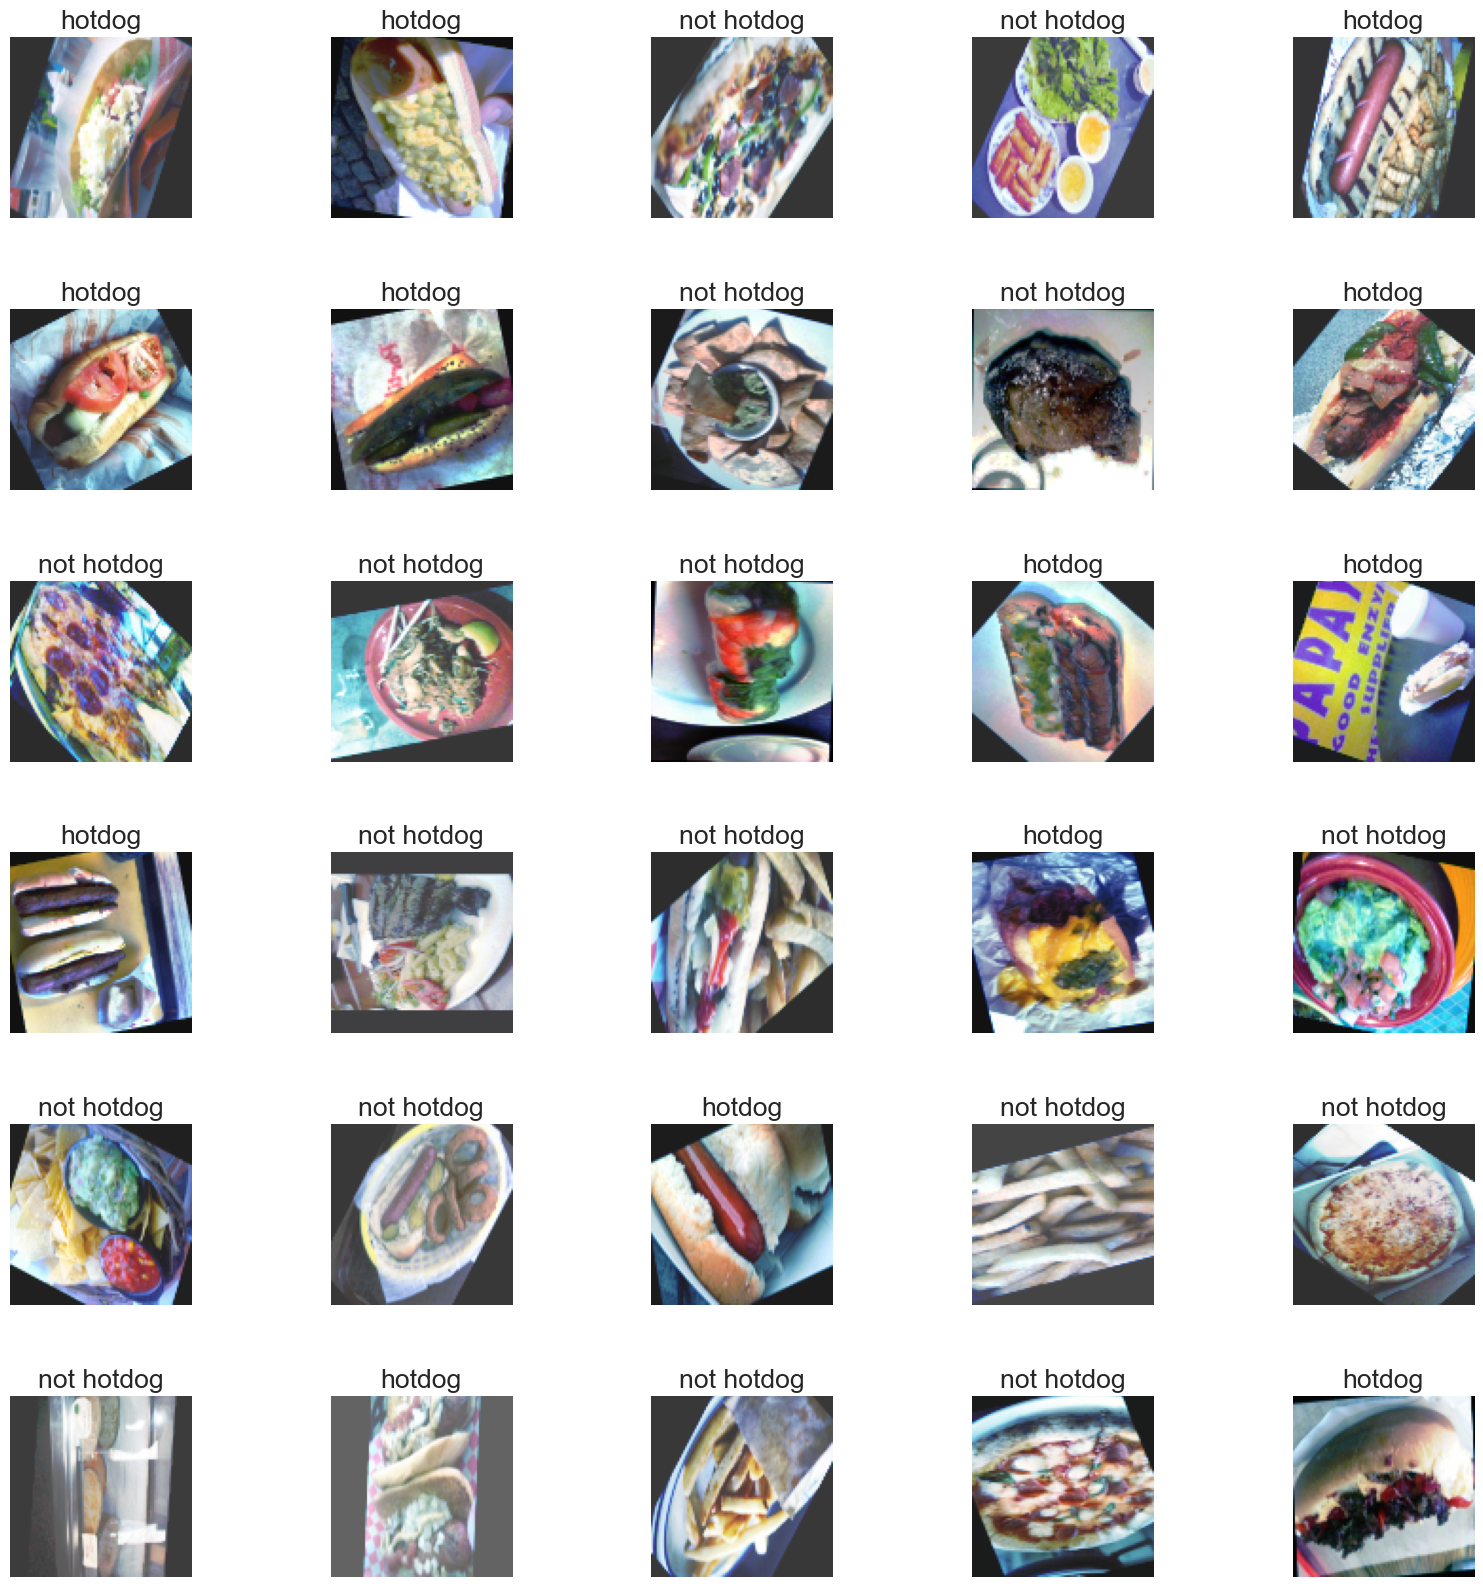

In [55]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(hotdog_test_x[n])
  plt.title(oob_preds[n])
  plt.axis('off')
plt.show()

### 2j. Questions

**Question 6:** What is the best accuracy that you are able to achieve on the test set? Briefly summarize the hyperparameters that were used in your model.

**Answer 6:**  We got 91% accuracy on the test set.  This was with default learning rate, 256 batch size over 2 epochs.  The logic was that we wanted as many weight updates as possible while having batches that represent our data well.  Because we only have 2 classes, we can use a fairly small batch size relative to our dataset size.  2 Epochs represetned 12800/256 updates which seems like plenty.

No points off for lower accuracy, but something less than 70% might be an indicator that something is wrong.
